In [24]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
from scipy import stats
from statsmodels.api import add_constant
from pandas.core import datetools
%matplotlib inline

In [25]:
month = {'JAN': 1, 'FEB':2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT':10, 'NOV': 11, 'DEC': 12}

In [26]:
# Import high frequency data

path =r'D:\data_raw' # Please put all .csv documents into one folder
company_list = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DWDP', 'GE', 'GS', \
                           'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', \
                            'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM' ] # Input company name as a list
company_data = {} # Store company data as a dictionary: {company_name1: data1, company_name2: data2, ...}
for company in company_list:
    frame = pd.DataFrame()
    list_ = []
    allFiles = glob.glob(path + '/' +company +'_' + '*.csv')
    allFiles.reverse()
    #print (allFiles)
    for file_ in allFiles:
        df = pd.read_csv(file_, index_col=None, header=0, usecols=[0,1], skiprows=[1,])
        list_.append(df)
    frame = pd.concat(list_)
    company_data[company] = frame
    company_data[company].index = pd.RangeIndex(len(company_data[company].index))

In [27]:
high_mom_daily_data = {}
list_big_data = []
for com in company_data.keys():
    list_temp = []
    date_idx = []
    high_mom_daily_data[com] = pd.DataFrame(columns = ['RDVar', 'RDSkew', 'RDKurt'])
    date_idx_s = np.array(company_data[com].loc[pd.isnull(company_data[com].Close), ].index)
    date_idx_e = np.append(date_idx_s[1:], company_data[com].shape[0])
    for i, j in zip(date_idx_s, date_idx_e):
        date = company_data[com]['Time Interval'][i][:9]
        d = date[:2]
        m = str(month[date[2:5]])
        y = date[5:]
        date_idx.append(d+'/'+m+'/'+y)
        log_r = np.log(company_data[com].Close[i+1: j]).diff().dropna()
        RDVar = np.sum(np.square(log_r))
        RDSkew = np.sqrt(len(log_r)) * np.sum(log_r**3) / RDVar**1.5
        RDKurt = len(log_r) * np.sum(log_r**4) / RDVar**2
        list_temp.append({'RDVar': RDVar, 'RDSkew': RDSkew, 'RDKurt': RDKurt})
    high_mom_daily_data[com] = high_mom_daily_data[com].append(list_temp)
    high_mom_daily_data[com].index = pd.to_datetime(date_idx, dayfirst=True)
    list_big_data.append(high_mom_daily_data[com])

In [175]:
big_data = pd.concat(list_big_data, axis = 1)
big_data.dropna(axis = 0, how = 'any', inplace = True)

In [33]:
for com in high_mom_daily_data.keys():
    index = company_list.index(com)
    high_mom_daily_data[com] = big_data.iloc[:, index : index+3]

In [176]:
# Import daily data

#company_daily = {}
list_daily = []
for com in company_list:
    company_daily[com] = pd.read_excel('D:\\daily_data_xls\\'+com+'_daily.xlsx', index_col = 0, header = 0)
    list_drop = list(company_daily[com].columns.values[:-1])
    company_daily[com].drop(list_drop, axis = 1, inplace = True)
    list_daily.append(company_daily[com])
    
big_data_daily = pd.concat(list_daily, axis = 1)
big_data_daily.dropna(axis = 0, how = 'any', inplace = True)

    #idx = high_mom_daily_data[com].index
    #company_daily[com] = company_daily[com].loc[idx, ]
    #company_daily[com]['Daily_logp'] = np.log(company_daily[com].iloc[:, 0])
    #company_daily[com]['Daily_logr'] = company_daily[com]['Daily_logp'].diff()
    #company_daily[com].index = high_mom_daily_data['AAPL'].index

In [177]:
super_big_data = pd.concat([big_data, big_data_daily], axis = 1)
super_big_data.dropna(axis = 0, how = 'any', inplace = True)

In [74]:
company_daily = {}
for com in high_mom_daily_data.keys():
    index = company_list.index(com)
    high_mom_daily_data[com] = super_big_data.iloc[:, index : index+3]
    company_daily[com] = pd.DataFrame(super_big_data.iloc[:, index+90])
    company_daily[com]['Daily_logp'] = np.log(company_daily[com].iloc[:, 0])
    company_daily[com]['Daily_logr'] = company_daily[com]['Daily_logp'].diff()

In [75]:
company_daily['AAPL'].shape

(1255, 3)

In [6]:
# Import DJIA daily
#DJIA = pd.read_csv('D:\daily_data\DJI_daily.csv', index_col = None, header = 0, usecols=[6])
#DJIA.index = high_mom_daily_data['AAPL'].index
#DJIA['daily_r'] = np.log(DJIA.iloc[:, 0]).diff()

In [ ]:
# Delete two dates
#date_to_delete = [pd.Timestamp('13/08/2013'), pd.Timestamp('12/09/2016')]
#for com in high_mom_daily_data.keys():
#    if date_to_delete[0] in high_mom_daily_data[com].index:
  #      high_mom_daily_data[com].drop(date_to_delete[0], inplace = True)
    #if date_to_delete[0] in company_daily[com].index:
    #    company_daily[com].drop(date_to_delete[0], inplace = True)
    #if date_to_delete[0] in DJIA.index:
       # DJIA.drop(date_to_delete[0], inplace = True)
    #if date_to_delete[1] in high_mom_daily_data[com].index:
    #  high_mom_daily_data[com].drop(date_to_delete[1], inplace = True)
    #if date_to_delete[1] in company_daily[com].index:
     #   company_daily[com].drop(date_to_delete[1], inplace = True)
    #if date_to_delete[1] in DJIA.index:
     #   DJIA.drop(date_to_delete[1], inplace = True)

In [76]:
# Combine two dataframes
for com in high_mom_daily_data.keys():
    high_mom_daily_data[com]['DR'] = company_daily[com].Daily_logr

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
# Save data
for com in high_mom_daily_data.keys():
    high_mom_daily_data[com].to_csv('D:\\output_data\\'+com+'.csv')

In [79]:
# daily close price by company matrix
price_com_mat = pd.DataFrame(columns = company_list)
for com in company_list:
    price_com_mat[com] = company_daily[com].iloc[:,0]

In [80]:
price_com_mat.to_csv('D:\\output_data\\'+'price_com_mat'+'.csv')

In [84]:
# Construct weekly data (5 trading days a week)
weekly_data = {}
for com in high_mom_daily_data.keys():
    weekly_data[com] = pd.DataFrame()
    weekly_data[com]['WR'] = high_mom_daily_data[com]['DR'].rolling(5).sum()[4::5]
    weekly_data[com]['RVol'] = np.sqrt(252.*high_mom_daily_data[com]['RDVar'].rolling(5).mean()[4::5])
    weekly_data[com]['RSkew'] = high_mom_daily_data[com]['RDSkew'].rolling(5).mean()[4::5]
    weekly_data[com]['RKurt'] = high_mom_daily_data[com]['RDKurt'].rolling(5).mean()[4::5]

In [24]:
#DJIA_weekly = DJIA['daily_r'].rolling(5).sum()[4::5]

In [25]:
#for com in weekly_data.keys():
    #print (weekly_data[com].shape)

In [85]:
# Split weekly data into train and test data
weekly_test_data = {}
for com in weekly_data.keys():
    weekly_test_data[com] = weekly_data[com][-50: ]
    weekly_data[com] = weekly_data[com][:-50]

In [86]:
for com in weekly_data.keys():
    print (com, weekly_data[com].shape)

AAPL (201, 4)
AXP (201, 4)
BA (201, 4)
CAT (201, 4)
CSCO (201, 4)
CVX (201, 4)
DIS (201, 4)
DWDP (201, 4)
GE (201, 4)
GS (201, 4)
HD (201, 4)
IBM (201, 4)
INTC (201, 4)
JNJ (201, 4)
JPM (201, 4)
KO (201, 4)
MCD (201, 4)
MMM (201, 4)
MRK (201, 4)
MSFT (201, 4)
NKE (201, 4)
PFE (201, 4)
PG (201, 4)
TRV (201, 4)
UNH (201, 4)
UTX (201, 4)
V (201, 4)
VZ (201, 4)
WMT (201, 4)
XOM (201, 4)


In [87]:
total_week = weekly_data['AAPL'].shape[0]

In [88]:
total_week

201

In [89]:
# Cross sectional regression
company_beta_pval = pd.DataFrame(columns = ['vol_intercept', 'b_vol', 'vol_p_val', 'skew_intercept', 'b_skew', \
                                                                                   'skew_p_val','kurt_intercept','b_kurt', 'kurt_p_val'])
list_cbp = []
for i in range(200):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in weekly_data.keys():
        date_index = weekly_data[com].index
        next_return.append(weekly_data[com].WR[date_index[i+1]])
        cur_vol.append(weekly_data[com].RVol[date_index[i]])
        cur_skew.append(weekly_data[com].RSkew[date_index[i]])
        cur_kurt.append(weekly_data[com].RKurt[date_index[i]])
    cur_vol = add_constant(cur_vol)
    cur_skew = add_constant(cur_skew)
    cur_kurt = add_constant(cur_kurt)
    lm_vol = sm.OLS(next_return, cur_vol).fit()
    lm_skew = sm.OLS(next_return, cur_skew).fit()
    lm_kurt = sm.OLS(next_return, cur_kurt).fit()
    
    list_cbp.append({'vol_intercept': lm_vol.params[0], 'b_vol': lm_vol.params[1], 'vol_p_val': lm_vol.pvalues[1], \
                                 'skew_intercept': lm_skew.params[0], 'b_skew': lm_skew.params[1], 'skew_p_val': lm_skew.pvalues[1],\
                                  'kurt_intercept': lm_kurt.params[0], 'b_kurt': lm_kurt.params[1], 'kurt_p_val': lm_kurt.pvalues[1]})
company_beta_pval = company_beta_pval.append(list_cbp)

In [154]:
# IC time series of vol, skew and kurt
weekly_IC = pd.DataFrame(columns = ['vol_Rank_IC', 'vol_pvalue','skew_Rank_IC', 'skew_pvalue', 'kurt_Rank_IC', 'kurt_pvalue'])
list_dict = []
for i in range(200):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in weekly_data.keys():
        date_index = weekly_data[com].index
        next_return.append(weekly_data[com].WR[date_index[i+1]])
        cur_vol.append(weekly_data[com].RVol[date_index[i]])
        cur_skew.append(weekly_data[com].RSkew[date_index[i]])
        cur_kurt.append(weekly_data[com].RKurt[date_index[i]])
    
    vol_IC, vol_p = stats.spearmanr(cur_vol, next_return)
    skew_IC, skew_p = stats.spearmanr(cur_skew, next_return)
    kurt_IC, kurt_p = stats.spearmanr(cur_kurt, next_return)
    
    list_dict.append({'vol_Rank_IC': vol_IC, 'vol_pvalue': vol_p, 'skew_Rank_IC': skew_IC, 'skew_pvalue': skew_p, \
                              'kurt_Rank_IC': kurt_IC, 'kurt_pvalue': kurt_p}) 
weekly_IC = weekly_IC.append(list_dict)
weekly_IC.index = weekly_data['AAPL'].index[1:]

In [156]:
IC_mean = weekly_IC.mean()
IR = weekly_IC.std()
IC_IR = IC_mean / IR
IC_IR

vol_Rank_IC     0.032920
vol_pvalue      1.576649
skew_Rank_IC   -0.025335
skew_pvalue     1.708368
kurt_Rank_IC   -0.067671
kurt_pvalue     1.680517
dtype: float64

Positive significant rate:  0.04 Negative significant rate:  0.04


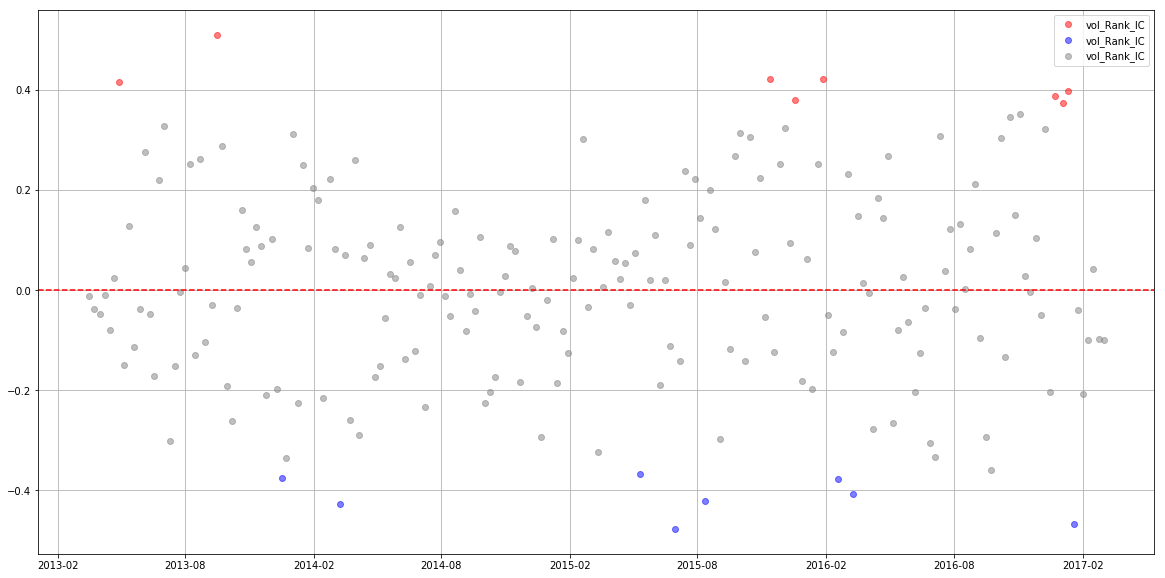

In [172]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.vol_pvalue[(weekly_IC.vol_pvalue < 0.05) & (weekly_IC.vol_Rank_IC >= 0)].index
y11 = weekly_IC.vol_Rank_IC[x11]
x12 = weekly_IC.vol_pvalue[(weekly_IC.vol_pvalue < 0.05) & (weekly_IC.vol_Rank_IC < 0)].index
y12 = weekly_IC.vol_Rank_IC[x12]
x2 = weekly_IC.vol_pvalue[weekly_IC.vol_pvalue >= 0.05].index
y2 = weekly_IC.vol_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(y11, 'o', alpha=0.5, color='red')
plt.plot(y12, 'o', alpha=0.5, color='blue')
plt.plot(y2, 'o', alpha=0.5, label='vol_Rank_IC', color='grey')
#plt.plot(range(200), [0 for i in range(200)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.025 Negative significant rate:  0.01


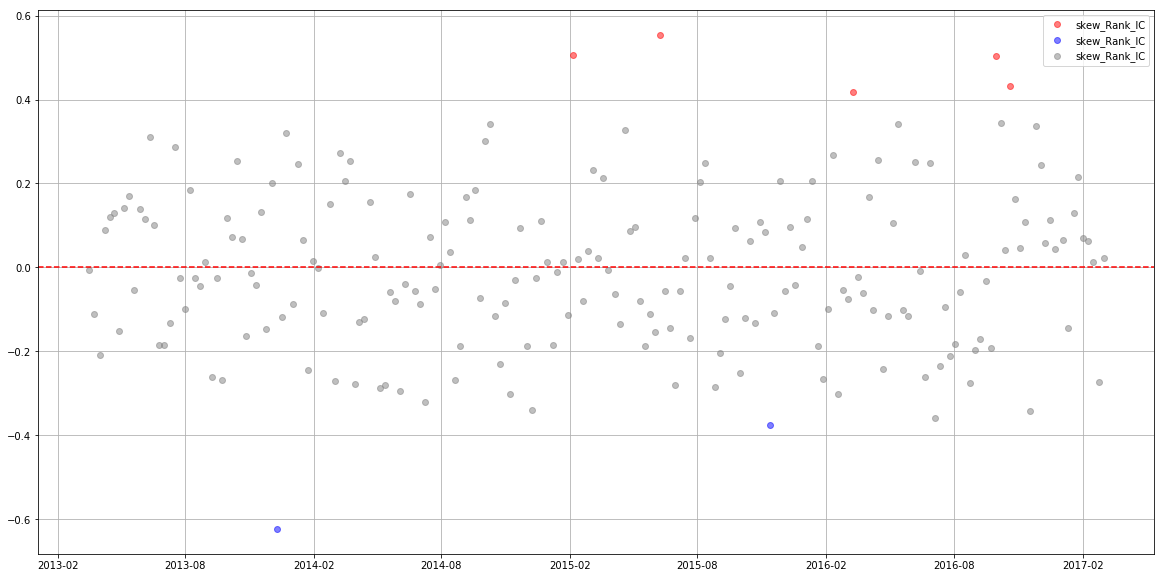

In [173]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.skew_pvalue[(weekly_IC.skew_pvalue < 0.05) & (weekly_IC.skew_Rank_IC >= 0)].index
y11 = weekly_IC.skew_Rank_IC[x11]
x12 = weekly_IC.skew_pvalue[(weekly_IC.skew_pvalue < 0.05) & (weekly_IC.skew_Rank_IC < 0)].index
y12 = weekly_IC.skew_Rank_IC[x12]
x2 = weekly_IC.skew_pvalue[weekly_IC.skew_pvalue >= 0.05].index
y2 = weekly_IC.skew_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(y11, 'o', alpha=0.5, color='red')
plt.plot(y12, 'o', alpha=0.5, color='blue')
plt.plot(y2, 'o', alpha=0.5, label='skew_Rank_IC', color='grey')
#plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.01 Negative significant rate:  0.05


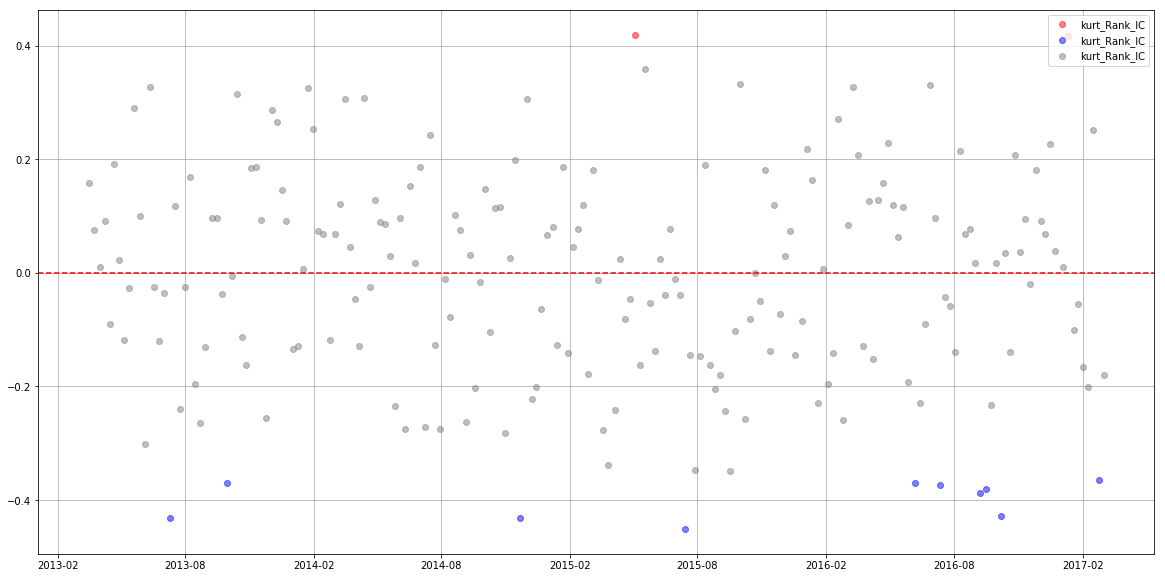

In [174]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.kurt_pvalue[(weekly_IC.kurt_pvalue < 0.05) & (weekly_IC.kurt_Rank_IC >= 0)].index
y11 = weekly_IC.kurt_Rank_IC[x11]
x12 = weekly_IC.kurt_pvalue[(weekly_IC.kurt_pvalue < 0.05) & (weekly_IC.kurt_Rank_IC < 0)].index
y12 = weekly_IC.kurt_Rank_IC[x12]
x2 = weekly_IC.kurt_pvalue[weekly_IC.kurt_pvalue >= 0.05].index
y2 = weekly_IC.kurt_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(x11, y11, 'o', alpha=0.5, color='red')
plt.plot(x12, y12, 'o', alpha=0.5, color='blue')
plt.plot(x2, y2, 'o', alpha=0.5, label='kurt_Rank_IC', color='grey')
#plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [98]:
# stocks having significant beta1_vol
company_beta_pval[['vol_intercept','b_vol','vol_p_val']][company_beta_pval.vol_p_val <0.05]

,vol_intercept,b_vol,vol_p_val
6,-0.098707,0.506457,0.015150
26,-0.025342,0.183342,0.049467
49,0.076629,-0.384577,0.034272
64,0.041546,-0.348393,0.042995
72,-0.021278,0.381762,0.027170
108,0.047008,-0.297159,0.020110
121,0.029443,-0.220118,0.020147
134,-0.052467,0.161272,0.037607
177,0.042844,-0.221597,0.032841
183,-0.050947,0.225621,0.023021


In [99]:
# stocks having significant beta1_skew
company_beta_pval[['skew_intercept','b_skew','skew_p_val']][company_beta_pval.skew_p_val <0.05]

,skew_intercept,b_skew,skew_p_val
15,0.001369,-0.022811,0.012904
37,0.000147,-0.037313,0.000697
39,0.035081,0.012966,0.039922
52,0.007355,-0.020430,0.012304
79,-0.023457,0.027844,0.033908
95,0.022033,0.074798,0.000257
112,-0.016669,0.024190,0.008055
178,-0.009505,0.027172,0.033073
179,0.005728,0.012842,0.037826


In [100]:
# Stocks having significant beta1_kurt
company_beta_pval[['kurt_intercept','b_kurt','kurt_p_val']][company_beta_pval.kurt_p_val <0.05]

,kurt_intercept,b_kurt,kurt_p_val
9,-0.032544,0.007907,0.029143
16,0.095760,-0.014050,0.005786
27,0.024241,-0.007289,0.029851
37,-0.052124,0.013169,0.028518
50,-0.027936,0.003537,0.040142
72,-0.008148,0.005920,0.031824
102,0.006799,-0.003958,0.022757
107,-0.046915,0.009274,0.006100
119,0.042006,-0.007815,0.009288
162,0.034121,-0.005132,0.030862


In [101]:
company_beta_pval.shape

(200, 9)

In [102]:
company_beta_pval.mean()

vol_intercept     0.001480
b_vol             0.005284
vol_p_val         0.468529
skew_intercept    0.002297
b_skew           -0.000175
skew_p_val        0.486634
kurt_intercept    0.003807
b_kurt           -0.000241
kurt_p_val        0.465589
dtype: float64

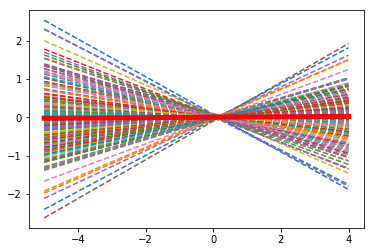

In [103]:
# Linear regression of return on vol
x = np.arange(-5,5)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.vol_intercept[row] + x*company_beta_pval.b_vol[row], '--')
plt.plot(x, company_beta_pval.vol_intercept.mean() + x*company_beta_pval.b_vol.mean(), color = 'red', lw = 5)
plt.show()

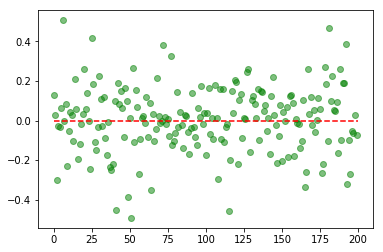

In [105]:
plt.plot(company_beta_pval.b_vol, 'o', alpha = 0.5, color = 'green')
plt.plot(range(201), [0 for i in range(201)], 'r--')

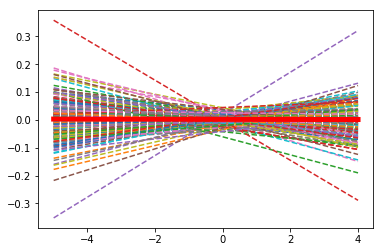

In [106]:
# Linear regression of return on skew
x = np.arange(-5,5)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.skew_intercept[row] + x*company_beta_pval.b_skew[row], '--')
plt.plot(x, company_beta_pval.skew_intercept.mean() + x*company_beta_pval.b_skew.mean(), color = 'red', lw = 5)
plt.show()

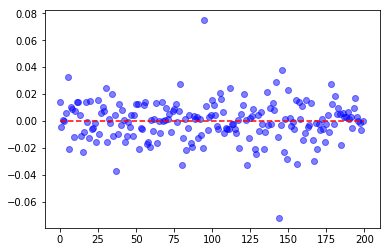

In [107]:
plt.plot(company_beta_pval.b_skew, 'o', alpha = 0.5, color = 'blue')
plt.plot(range(201), [0 for i in range(201)], 'r--')

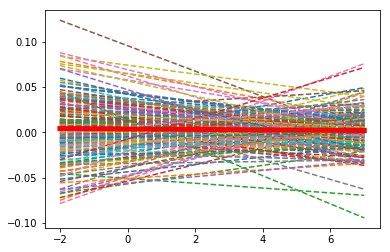

In [108]:
# Linear regression of return on kurt
x = np.arange(-2, 8)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.kurt_intercept[row] + x*company_beta_pval.b_kurt[row], '--')
plt.plot(x, company_beta_pval.kurt_intercept.mean() + x*company_beta_pval.b_kurt.mean(), color = 'red', lw = 5)
plt.show()

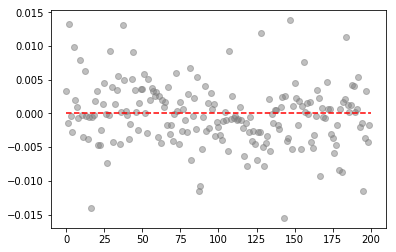

In [109]:
plt.plot(company_beta_pval.b_kurt, 'o', alpha = 0.5, color = 'grey')
plt.plot(range(201), [0 for i in range(201)], 'r--')

In [134]:
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_vol = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    vol_this_week = sorted([(com, weekly_data[com].RVol[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    #print (vol_this_week)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*vol_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        sum_r = 0
        for com in cur_group:
            sum_r += weekly_data[com].WR[week+1]
        group_return_list.append(sum_r/n_stock_grp)
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_vol = return_by_group_vol.append(tmp_list)
return_by_group_vol.index = weekly_data['AAPL'].index[1:]

In [136]:
return_by_group_vol.sum()

group1    0.427763
group2    0.534492
group3    0.597500
dtype: float64

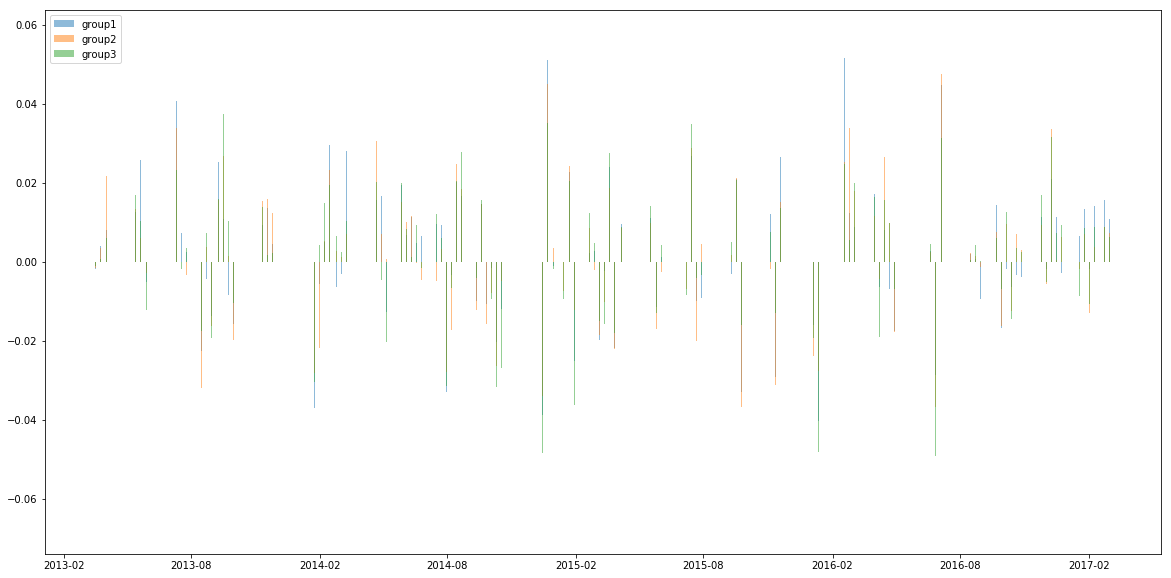

In [137]:
plt.figure(figsize=(20,10))
plt.bar(return_by_group_vol.group1.index, return_by_group_vol.group1, alpha = 0.5, label = 'group1')
plt.bar(return_by_group_vol.group2.index, return_by_group_vol.group2, alpha = 0.5, label = 'group2')
plt.bar(return_by_group_vol.group3.index, return_by_group_vol.group3, alpha = 0.5, label = 'group3')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

In [138]:
return_by_group_vol['market'] = (return_by_group_vol.group1 + return_by_group_vol.group2 + return_by_group_vol.group3)/3
plt.plot(return_by_group_vol.market.index, return_by_group_vol.market.cumsum(), label = 'group_avg', lw = 4)

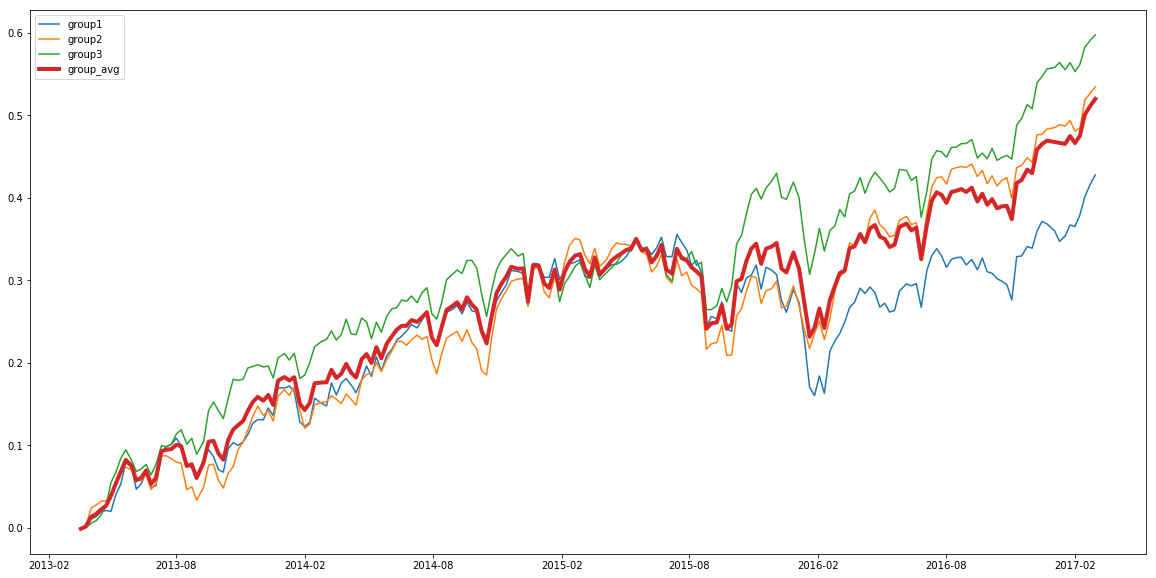

In [139]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_vol.group1.index, return_by_group_vol.group1.cumsum(), label = 'group1')
plt.plot(return_by_group_vol.group2.index, return_by_group_vol.group2.cumsum(), label = 'group2')
plt.plot(return_by_group_vol.group3.index, return_by_group_vol.group3.cumsum(), label = 'group3')
plt.plot(return_by_group_vol.market.index, return_by_group_vol.market.cumsum(), label = 'group_avg', lw = 4)
#plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

In [143]:
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_skew = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    skew_this_week = sorted([(com, weekly_data[com].RSkew[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    group_return_list = []
    for i in range(len(group_name)):
        cur_group = skew_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp]
        sum_r = 0
        for com, _ in cur_group:
            sum_r += weekly_data[com].WR[week+1]
        group_return_list.append(sum_r/n_stock_grp)
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_skew = return_by_group_skew.append(tmp_list)
return_by_group_skew.index = weekly_data['AAPL'].index[1:]

In [144]:
return_by_group_skew.sum()

group1    0.470809
group2    0.659042
group3    0.429904
dtype: float64

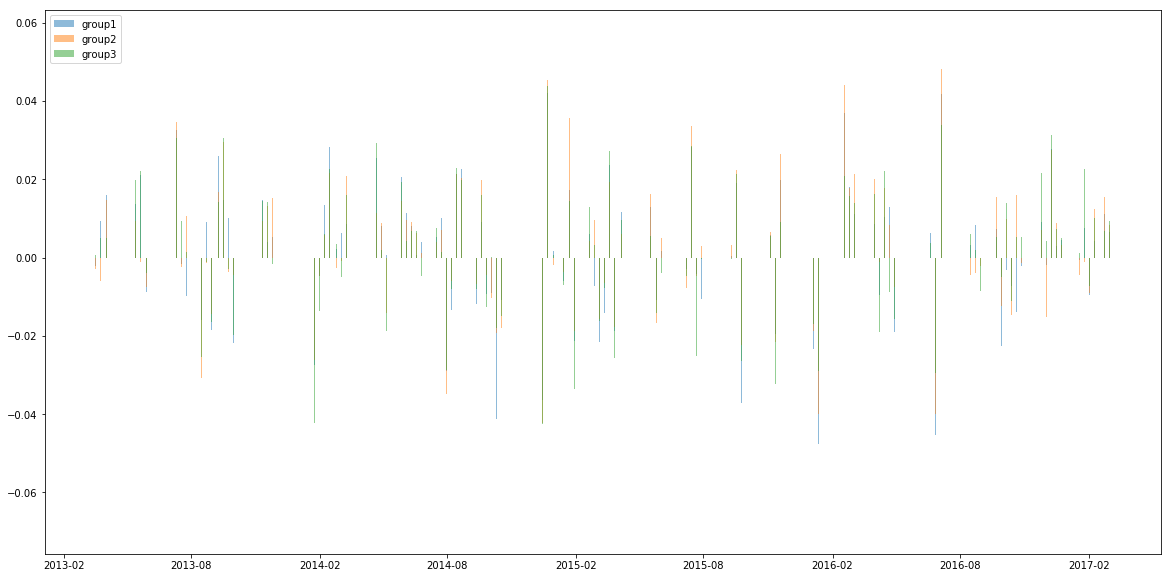

In [145]:
plt.figure(figsize=(20,10))
plt.bar(return_by_group_skew.group1.index, return_by_group_skew.group1, alpha = 0.5, label = 'group1')
plt.bar(return_by_group_skew.group2.index, return_by_group_skew.group2, alpha = 0.5, label = 'group2')
plt.bar(return_by_group_skew.group3.index, return_by_group_skew.group3, alpha = 0.5, label = 'group3')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)

plt.legend(loc = 'upper left')

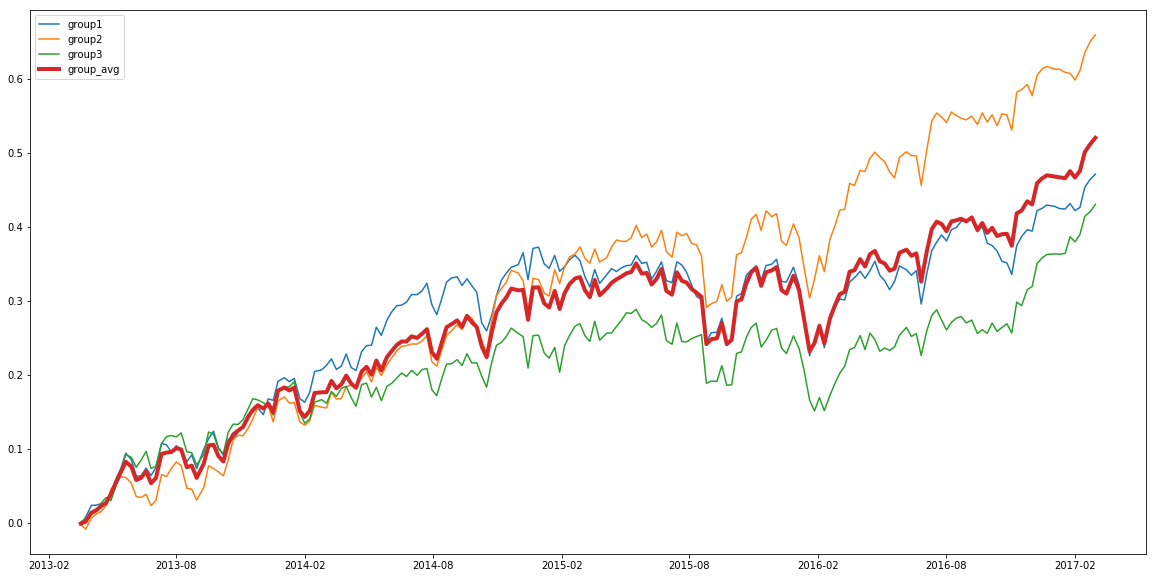

In [151]:
plt.figure(figsize = (20,10))
plt.plot(return_by_group_skew.group1.index, return_by_group_skew.group1.cumsum(), label = 'group1')
plt.plot(return_by_group_skew.group2.index, return_by_group_skew.group2.cumsum(), label = 'group2')
plt.plot(return_by_group_skew.group3.index, return_by_group_skew.group3.cumsum(), label = 'group3')
#plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
return_by_group_skew['market'] = (return_by_group_skew.group1 + return_by_group_skew.group2 + return_by_group_skew.group3)/3
plt.plot(return_by_group_skew.market.index, return_by_group_skew.market.cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')

In [147]:
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_kurt = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    kurt_this_week = sorted([(com, weekly_data[com].RKurt[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    #print (vol_this_week)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*kurt_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        sum_r = 0
        for com in cur_group:
            sum_r += weekly_data[com].WR[week+1]
        group_return_list.append(sum_r/n_stock_grp)
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_kurt = return_by_group_kurt.append(tmp_list)
return_by_group_kurt.index = weekly_data['AAPL'].index[1:]

In [148]:
return_by_group_kurt.sum()

group1    0.478906
group2    0.664788
group3    0.416060
dtype: float64

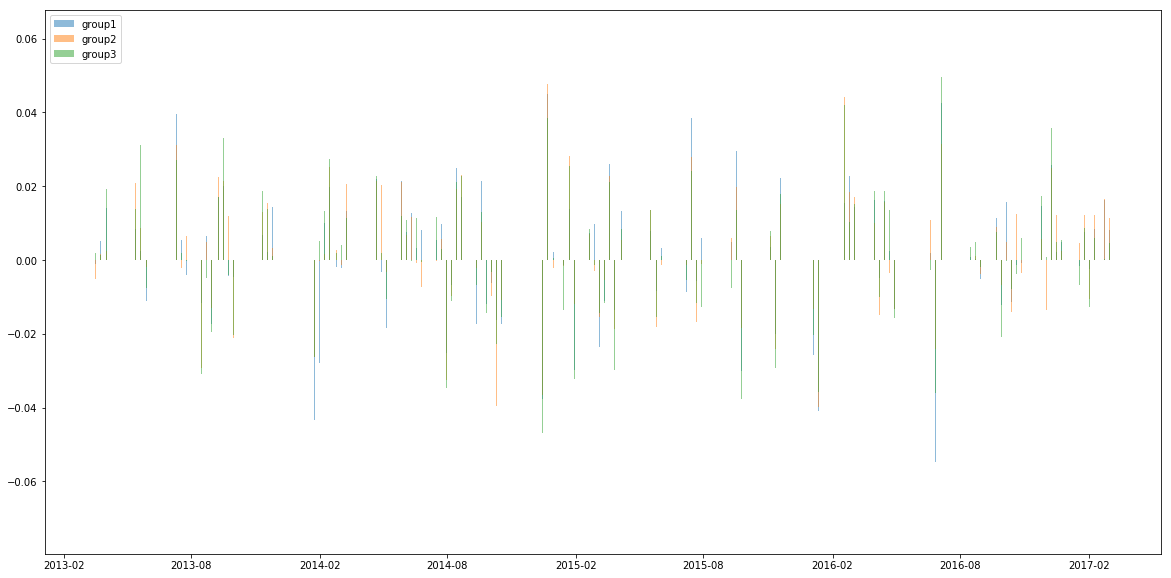

In [149]:
plt.figure(figsize=(20,10))
plt.bar(return_by_group_kurt.group1.index, return_by_group_kurt.group1, alpha = 0.5, label = 'group1')
plt.bar(return_by_group_kurt.group2.index, return_by_group_kurt.group2, alpha = 0.5, label = 'group2')
plt.bar(return_by_group_kurt.group3.index, return_by_group_kurt.group3, alpha = 0.5, label = 'group3')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

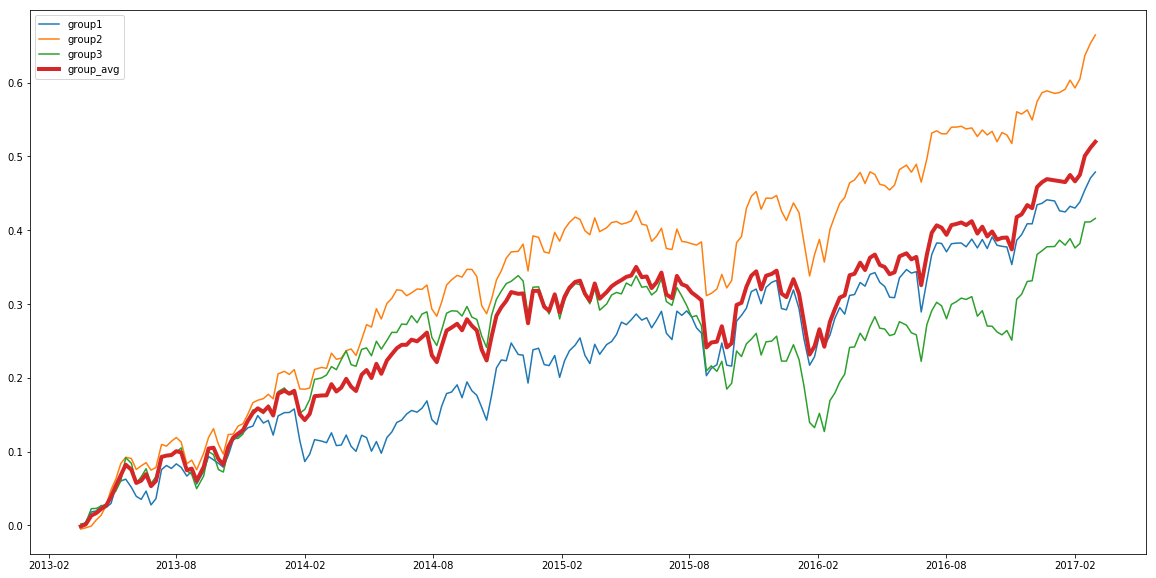

In [152]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_kurt.group1.index, return_by_group_kurt.group1.cumsum(), label = 'group1')
plt.plot(return_by_group_kurt.group2.index, return_by_group_kurt.group2.cumsum(), label = 'group2')
plt.plot(return_by_group_kurt.group3.index, return_by_group_kurt.group3.cumsum(), label = 'group3')
#plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
return_by_group_kurt['market'] = (return_by_group_kurt.group1 + return_by_group_kurt.group2 + return_by_group_kurt.group3)/3
plt.plot(return_by_group_kurt.market.index, return_by_group_kurt.market.cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')